## Notes: 

If you don't have graphviz installed: 

For Mac, run `brew install graphviz` in your terminal.
For Windows/Linuz, run `pip install graphviz` in your terminal. 

In [2]:

from sklearn.datasets import load_iris
from sklearn import tree
import pandas as pd
import graphviz
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import randint
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
np.random.seed(0)

# Decision Trees

This notebook will walk through how to use decision trees with bagging and boosting methods in sklearn as well as introduce the bias variance tradeoff.

First load the iris dataset into a pandas dataframe.

In [46]:
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])


We will then add the species label to each datapoint using the encoding given in the dataset to understand what the overall dataset looks like.

In [5]:
df['species'] = df['target']
df.drop(['target'],axis=1, inplace=True)
df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


Split the dataframe into training and validation data.

In [49]:
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
train, test = df[df['is_train']==True], df[df['is_train']==False]
train = train.drop(['is_train'], axis = 1)
test = test.drop(['is_train'], axis = 1)

Separate the labels and feature from both the training and test datasets and refactorize the labels.

In [7]:
train_features = train[train.columns[0:4]]
train_labels =  train['species']
test_features = test[test.columns[0:4]]
test_labels =test['species']
print(np.shape(test_features))
print(np.shape(test_labels))

(32, 4)
(32,)


Create a basic decision tree which minimizes entropy and fit it to the training data.

In [8]:
# create decision tree that minimizes entropy 
clf = tree.DecisionTreeClassifier()

#fit on to training data
trained_model = clf.fit(train_features,train_labels)

trained_model


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

We can visualize this decision tree by using graphviz. Visualizing a decision tree allows us to easily interpret how the predictions or classifications are made because each split is clearly defined.

Notice how with each split the weighted entropy of the two branches is less than the entropy of the parent.


In [9]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)

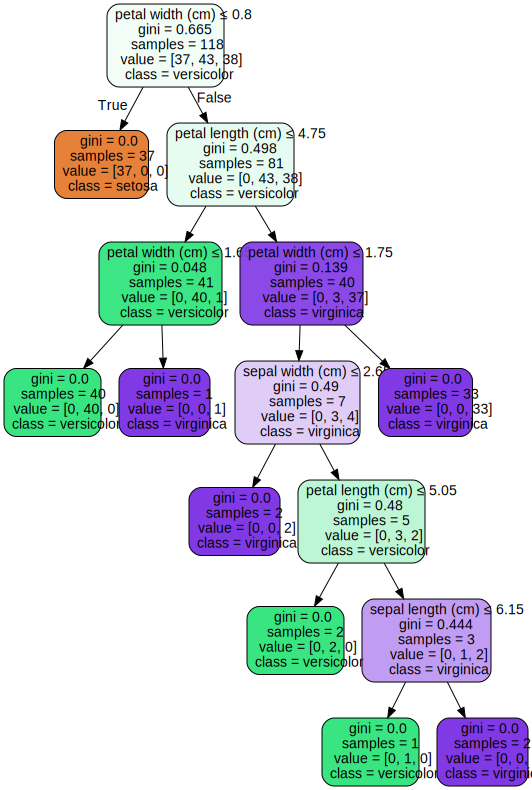

In [10]:
graph = graphviz.Source(dot_data) 
graph

Compute the training and validation accuracies. 

In [31]:
# compute training accuracy using score
train_accuracy = accuracy_score(train_labels, trained_model.predict(train_features))
test_accuracy = accuracy_score(test_labels, trained_model.predict(test_features))

test_accuracy

0.9375

In [32]:
# compute validation accuracy using score
scores = cross_val_score(clf, iris.data, iris.target, cv=5)
scores



array([0.96666667, 0.96666667, 0.9       , 0.96666667, 1.        ])

We will now use Grid Search to find a good set of hyperparameters which attempt to regualize the tree.

In [22]:
parameters = {"min_samples_split": [2, 10],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }
# use GridSearchCV
gridsearch = GridSearchCV(tree.DecisionTreeClassifier(), param_grid = parameters)
# fit gridsearch on training data and labels
gridsearch.fit(train_features,train_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 10], 'max_depth': [None, 2, 5, 10], 'min_samples_leaf': [1, 5, 10], 'max_leaf_nodes': [None, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
# get best decision tree from gridsearch
best_tree = gridsearch.best_estimator_

# fit best decision on training data and labels
best_tree.fit(train_features,train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Run the following code to visualize the new tree.

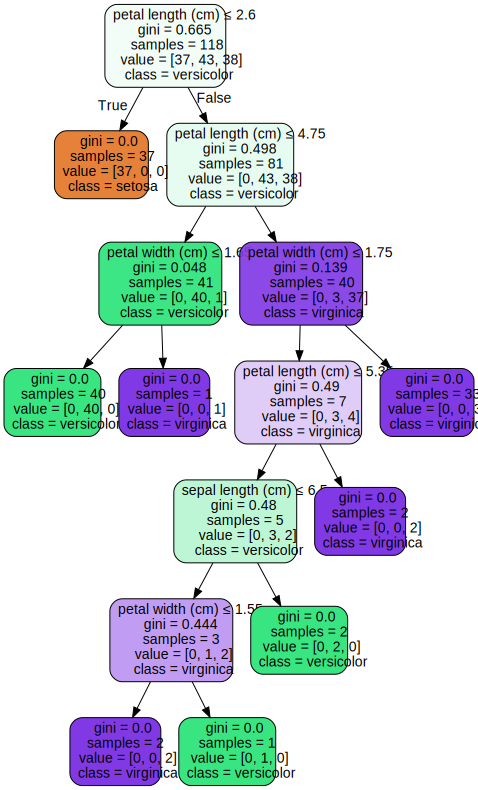

In [25]:
dot_data = tree.export_graphviz(best_tree, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data) 
graph

You should see that the difference between the validation and training accuracies is not as large as before.

In [26]:
# use score to get best tree training accuracy
best_tree.score(train_features,train_labels)

1.0

In [27]:
# use score to get best tree validation accuracy
best_tree.score(test_features,test_labels)

0.9375

Now train a Random Forest Classifier on the same dataset. 

In [34]:
# RandomForestClassifier minimizing entropy. set estimators to 100
a = RandomForestClassifier(n_estimators = 100)
# fit classifier on training data 
a.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
# use score to get training accuracy
a.score(train_features,train_labels)

1.0

In [37]:
# use score to get validation accuracy
a.score(test_features,test_labels)

0.9375

Train an AdaBoost Classifier on the same dataset. 

In [38]:
default_tree = tree.DecisionTreeClassifier(max_depth=2, min_samples_leaf=3, criterion = 'entropy')

In [39]:
# initialize AdaBoostClassifier based on default tree
z = AdaBoostClassifier()

In [40]:
# fit boost classifier on training data
z.fit(train_features,train_labels)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [42]:
# use score to get boost training accuracy
z.score(train_features,train_labels)

0.9491525423728814

In [43]:
# use score to get boost validation accuracy
z.score(test_features,test_labels)

0.96875

## Questions: 

1) In your own words, explain what a decision tree is.
    
A decision tree is a tree that becomes more pure as you go down the tree, since it splits the values based on certain attribues. 


2) What does it mean to regularize a decision tree?

Regularizing a decision tree reduces its tendency to overfit. 
    
3) What are some ways you can regularize a decision tree?
    
Bagging parts of the tree or limiting the length of the tree. 

4) Why do decision trees get higher training accuracy than testing accuracy?

They get higher training accuracy because they fit perfectly to the data. 

5) Why are the testing and training accuracy not so different from each other when we find the best decision tree (`best_tree`)?

This means that the dataset is trained well, or that the testing data is very similar to the training data?


6) In your own words, explain how a random forest works and how regularization works in random forests.

Random forest take many decision trees, all trained differently. Finally, the trees are averged; this reduces variability. 


7) Explain in your own words and in detail what GridSearchCV does.
    
GridSearchCV varies parameters and selects the best parameter.


8) What does boosting do and why is it useful? Connect this back to what we did with the iris dataset. 

Boosting takes many classifiers and regularizes the data. It reduces bias and is an ensembling technique.
